# Optimisation de la gestion d'une boutique "Bottleneck"

## Importations des librairies et chargement des fichiers dans des dataframes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Chargement des données

In [2]:
# Chargement de mes fichier csv dans un dataframe
produit = pd.read_csv('/Users/Hamza/Downloads/erp.csv',sep=';')
liaison = pd.read_csv('/Users/Hamza/Downloads/liaison.csv', sep=';')
web = pd.read_csv('/Users/Hamza/Downloads/web.csv', sep=';')

# Nettoyage des données

### 1) D'abord les données provenant de l'ERP du dataframe appelé Produit

In [3]:
# Visualisation 
produit.head()

,product_id,onsale_web,price,stock_quantity,stock_status
0,3847,1,"24,2",0,outofstock
1,3849,1,"34,3",0,outofstock
2,3850,1,"20,8",0,outofstock
3,4032,1,"14,1",0,outofstock
4,4039,1,46,0,outofstock


In [4]:
# Je regarde le type des variables
produit.dtypes

product_id         int64
onsale_web         int64
price             object
stock_quantity     int64
stock_status      object
dtype: object

### La variable price n'est pas adapté, je converti en float

In [5]:
# Je remplace les virgules par des points sinon le changement en float n'est pas possible
# puis je change le type de ma colonne en float

produit['price'] = produit['price'].str.replace(',','.').astype('float64')
#je verifie
produit['price'].dtype

dtype('float64')

In [6]:
# J'affiche les stats du df produit
produit.describe(include='all')

,product_id,onsale_web,price,stock_quantity,stock_status
count,825.000000,825.000000,825.000000,825.000000,825
unique,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,instock
freq,NaN,NaN,NaN,NaN,638
mean,5162.597576,0.869091,32.415636,26.496970,NaN
std,902.644635,0.337506,26.795849,45.892422,NaN
min,3847.000000,0.000000,5.200000,0.000000,NaN
25%,4348.000000,1.000000,14.600000,1.000000,NaN
50%,4907.000000,1.000000,24.400000,11.000000,NaN
75%,5805.000000,1.000000,42.000000,34.000000,NaN


### On note qu'il y a 825 valeurs dans la colonne product_id. La colonne product_id est candidate pour être clé primaire, je verife son unicité et s'il y a des manquants.

### Je vérifie l'unicité

In [7]:
# Je demande la longueur des valeurs distinctes de ma colonne product_id
len(pd.unique(produit['product_id']))

825

In [8]:
# je regarde également les valeurs manquantes
produit.isnull().sum()

product_id        0
onsale_web        0
price             0
stock_quantity    0
stock_status      0
dtype: int64

### Ma variable product_id est a des valeurs unique et ne contient aucune valeur nulle. Elle sera donc clé primaire pour ma jointure.

In [9]:
# je regarde également si le df contient des doublons
produit.duplicated().sum()

0

### Le dataframe produit est propre.   Ma clé primaire est <u>product_id</u>

### 2) Regardons maintenant le df liaison qui est le fichier qui fait le lient entre l'ERP (produit) et les données du web (web). On veut essentiellement savoir ici si notre fichier contient des doublons, je sais deja qu'il peut y avoir des valeurs manquantes au vu des infos de mission. On vérifie tout cela.

In [10]:
# J'affiche les premieres lignes de df liaison
liaison.head()

,product_id,id_web
0,3847,15298
1,3849,15296
2,3850,15300
3,4032,19814
4,4039,19815


In [11]:
liaison.dtypes

product_id     int64
id_web        object
dtype: object

In [12]:
# je change le type de ma colonne procuct_id sans quoi mes stats ne s'affiche pas correctement
liaison['product_id'] = liaison['product_id'].astype('object')

In [13]:
#je regarde les stats
liaison.describe(include='all')

,product_id,id_web
count,825,734
unique,825,734
top,3847,15298
freq,1,1


### On retrouve les 825 produits correspondant au produit de l'ERP, et pour les référence web on en a 734. Si nous faisons 825 - 734 = 91.

### On retrouve ces 91 valeurs manquantes ci-dessous.

In [14]:
# Je check les valeurs manquantes 
liaison.isnull().sum()

product_id     0
id_web        91
dtype: int64

### Ici, il ne faut pas supprimer ces valeurs manquantes car nous avons besoin des valeurs correspondantes dans la colonne product_id pour la jointure.

In [15]:
# Je check les doublons
liaison.duplicated().sum()

0

### il n'y a pas de doublons.

### 3) A présent, interessons nous au fichier "web" de la boutique en ligne

In [16]:
# Visualisation
web.head()

,sku,total_sales,post_author,post_date
0,bon-cadeau-25-euros,10,1,01/06/2018 13:53
1,15298,6,2,08/02/2018 12:58
2,15296,0,2,08/02/2018 13:49
3,15300,0,2,08/02/2018 14:08
4,19814,3,2,09/02/2018 14:01


In [17]:
# je renomme la colonne SKU  en id_web afin qu'elle corresponde pour ma jointure
web.rename(columns= {'sku':'id_web'}, inplace=True)

In [18]:
#Les stats
web.describe(include="all")

,id_web,total_sales,post_author,post_date
count,1427,1429.000000,1429.000000,1429
unique,714,NaN,NaN,710
top,bon-cadeau-25-euros,NaN,NaN,18/01/2020 10:54
freq,2,NaN,NaN,4
mean,NaN,4.009797,1.998600,NaN
std,NaN,8.512878,0.037398,NaN
min,NaN,0.000000,1.000000,NaN
25%,NaN,0.000000,2.000000,NaN
50%,NaN,1.000000,2.000000,NaN
75%,NaN,4.000000,2.000000,NaN


### Ce fichier compte 1427 valeurs id_web et 714 de ces valeurs sont uniques donc il se peut que le fichier soit en double, on vérifie

In [19]:
# je regarde les doublons
web.duplicated().sum()

713

In [20]:
#je ragarde mes doublons que je tri pour voir les doublons l'un en dessous de l'autre
web[web.duplicated(keep=False)].sort_values('id_web', ascending=False).head(30)

,id_web,total_sales,post_author,post_date
0,bon-cadeau-25-euros,10,1,01/06/2018 13:53
1125,bon-cadeau-25-euros,10,1,01/06/2018 13:53
1117,9937,4,2,17/05/2018 12:55
403,9937,4,2,17/05/2018 12:55
213,9636,0,2,22/03/2018 10:44
927,9636,0,2,22/03/2018 10:44
918,9562,0,2,02/03/2018 10:57
204,9562,0,2,02/03/2018 10:57
1220,8463,0,2,26/11/2018 11:25
506,8463,0,2,26/11/2018 11:25


### On constate bien que les id_web sont en doubles, il faut les supprimer

In [21]:
#je supprime ces doublons
web.drop_duplicates(inplace=True)
#je vérifie
web.duplicated().sum()

0

### Maintenant, vérifions l'unicité de ma colonne id_web qui sera clé primaire 

In [22]:
# Le stats
web.describe(include='all')

,id_web,total_sales,post_author,post_date
count,714,716.000000,716.000000,716
unique,714,NaN,NaN,710
top,bon-cadeau-25-euros,NaN,NaN,18/01/2020 10:54
freq,1,NaN,NaN,2
mean,NaN,4.001397,1.998603,NaN
std,NaN,8.508901,0.037372,NaN
min,NaN,0.000000,1.000000,NaN
25%,NaN,0.000000,2.000000,NaN
50%,NaN,1.000000,2.000000,NaN
75%,NaN,4.000000,2.000000,NaN


### on retrouve bien 714 valeurs uniques

In [23]:
# je regarde les valeurs manquantes
web.isnull().sum()

id_web         2
total_sales    0
post_author    0
post_date      0
dtype: int64

In [24]:
manquant = web['id_web'].isnull()
web[manquant]

,id_web,total_sales,post_author,post_date
447,NaN,0,2,31/07/2018 12:07
448,NaN,0,2,08/08/2018 11:23


### Ici, ces 2 valeurs manquantes n'auront donc pas de correspondance avec mon fichier de liaison donc elle sont inutile, je peux les supprimer

In [25]:
# je supprime ces 2 lignes
web.dropna(inplace=True)
# je check
web.isnull().sum()

id_web         0
total_sales    0
post_author    0
post_date      0
dtype: int64

### Voila !! Après ce nettoyage des dataframes distinct, on peut faire nos jointures.

# Jointures

In [26]:
# je joins mon df produit avec le df de liaison
df1 = produit.merge(liaison) 
#la jointure se fait automatiquement sur la colonne product_id et en 'inner' par defaut

### Comme nous l'avons vu plus haut, le df produit et le df liasion contiennent tous deux 825 valeurs unique donc on s'attend a ce que notre dataframe joint contienne 825 valeurs

In [27]:
# je vérifie
df1

,product_id,onsale_web,price,stock_quantity,stock_status,id_web
0,3847,1,24.2,0,outofstock,15298
1,3849,1,34.3,0,outofstock,15296
2,3850,1,20.8,0,outofstock,15300
3,4032,1,14.1,0,outofstock,19814
4,4039,1,46.0,0,outofstock,19815
...,...,...,...,...,...,...
820,7203,0,45.0,30,instock,NaN
821,7204,0,45.0,9,instock,NaN
822,7247,1,54.8,23,instock,13127-1
823,7329,0,26.5,14,instock,14680-1


### Maintenant, je joint mon df1 avec mon df web. On sait que le df web contient 714 valeurs donc en faisant une jointure 'inner' (intersection) avec mon df1 contenant 825 valeurs; le resultat sera un dataframe de 714 valeurs, la jointure élimine les manquants car aucune correspondance 

In [28]:
df2 = df1.merge(web)
# Cette fois, la jonture se fait automatiquement sur la colonne id_web 

In [29]:
df2

,product_id,onsale_web,price,stock_quantity,stock_status,id_web,total_sales,post_author,post_date
0,3847,1,24.2,0,outofstock,15298,6,2,08/02/2018 12:58
1,3849,1,34.3,0,outofstock,15296,0,2,08/02/2018 13:49
2,3850,1,20.8,0,outofstock,15300,0,2,08/02/2018 14:08
3,4032,1,14.1,0,outofstock,19814,3,2,09/02/2018 14:01
4,4039,1,46.0,0,outofstock,19815,0,2,12/02/2018 09:04
...,...,...,...,...,...,...,...,...,...
709,6930,1,8.4,83,instock,16135,5,2,25/04/2020 13:22
710,7023,1,27.5,15,instock,15891,0,2,02/05/2020 14:53
711,7025,1,69.0,2,instock,15887,0,2,02/05/2020 15:00
712,7247,1,54.8,23,instock,13127-1,0,2,09/06/2020 15:42


In [30]:
df2.isnull().sum()

product_id        0
onsale_web        0
price             0
stock_quantity    0
stock_status      0
id_web            0
total_sales       0
post_author       0
post_date         0
dtype: int64

In [31]:
df2.duplicated().sum()

0

# Mon dataframe est prêt pour l'analyse

### 1 ) Calcul du chiffre d'affaires par produit.

In [32]:
# Création d'une colonne qui calcule le CA par produit (ex  : 24.2 x 6 = 145.2 pour le 1ère ligne)
df2['CA / produit'] = df2['total_sales'] * df2['price']
df2


,product_id,onsale_web,price,stock_quantity,stock_status,id_web,total_sales,post_author,post_date,CA / produit
0,3847,1,24.2,0,outofstock,15298,6,2,08/02/2018 12:58,145.2
1,3849,1,34.3,0,outofstock,15296,0,2,08/02/2018 13:49,0.0
2,3850,1,20.8,0,outofstock,15300,0,2,08/02/2018 14:08,0.0
3,4032,1,14.1,0,outofstock,19814,3,2,09/02/2018 14:01,42.3
4,4039,1,46.0,0,outofstock,19815,0,2,12/02/2018 09:04,0.0
...,...,...,...,...,...,...,...,...,...,...
709,6930,1,8.4,83,instock,16135,5,2,25/04/2020 13:22,42.0
710,7023,1,27.5,15,instock,15891,0,2,02/05/2020 14:53,0.0
711,7025,1,69.0,2,instock,15887,0,2,02/05/2020 15:00,0.0
712,7247,1,54.8,23,instock,13127-1,0,2,09/06/2020 15:42,0.0


In [33]:
# Je regarde le type de ma colonne créé
df2['CA / produit'].dtype

dtype('float64')

### 2 ) Calcul du chiffre d'affaire total

In [34]:
CA = df2['CA / produit'].sum()
CA

70568.6

## Le chiffre d'affaire total est de 70568 EUROS

# A présent, faisont l'analyse univarié de notre variable price, regarder sa distribution, lister les eventuelles valeurs "aberrantes"

### Le terme de valeur aberrante est souvent abusif :  il ne faut pas confondre valeurs aberrantes et valeurs atypiques ou outliers, les premières sont des valeurs qui n'ont pas de sens comme des erreurs, les secondes ont du sens, par exemple, des valeurs elevées par rapport à une moyenne.... On va verifier tout cela.

In [35]:
#j'affiche les stats de df2
df2.describe(include='all')

,product_id,onsale_web,price,stock_quantity,stock_status,id_web,total_sales,post_author,post_date,CA / produit
count,714.0,714.0,714.000000,714.000000,714,714,714.000000,714.000000,714,714.000000
unique,714.0,NaN,NaN,NaN,2,714,NaN,NaN,708,NaN
top,3847.0,NaN,NaN,NaN,instock,15298,NaN,NaN,18/01/2020 10:54,NaN
freq,1.0,NaN,NaN,NaN,574,1,NaN,NaN,2,NaN
mean,NaN,1.0,32.493137,28.746499,NaN,NaN,4.012605,1.998599,NaN,98.835574
std,NaN,0.0,27.810525,48.012608,NaN,NaN,8.518183,0.037424,NaN,307.685071
min,NaN,1.0,5.200000,0.000000,NaN,NaN,0.000000,1.000000,NaN,0.000000
25%,NaN,1.0,14.100000,2.000000,NaN,NaN,0.000000,2.000000,NaN,0.000000
50%,NaN,1.0,23.550000,12.000000,NaN,NaN,1.000000,2.000000,NaN,15.250000
75%,NaN,1.0,42.175000,35.000000,NaN,NaN,4.000000,2.000000,NaN,91.150000


### Un premier constat : les valeurs de prix vont 5.20 à 225, l'écart semble grand ! Surtout lorsque l'on regarde les pourcentage de quantiles, on voit que les 3/4 des valeurs sont en dessous de 42.17

### Regardons la distribution des valeurs "price" dans un histogramme 

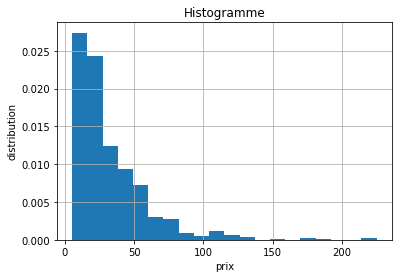

In [36]:
df2['price'].hist(density=True, bins=20)
plt.title('Histogramme')
plt.xlabel('prix')
plt.ylabel('distribution')
plt.show()

### Ci dessus, on voit que la distribution des prix se concentre sur des les valeurs inférieur à 60, en d'autres termes, <b>beaucoup de ventes se font sur des petits prix.</b>

### Ce que l'on peut faire également, c'est de regarder comment se concentre les sommes d'argents recueillis, est-ce que ces sommes d'argent se concentre sur quelques ventes ou sont étalées sur plusieurs ?

## Courbe de Lorenz : mesure de concentration

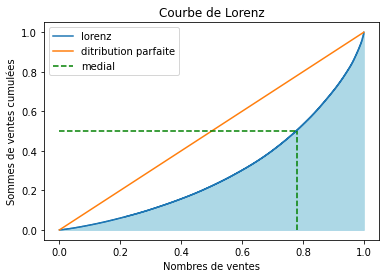

In [37]:
# Affichons une courbe de Lorenz pour voir si les ventes sont bien répartis

vente = df2['price'].values          # je prend mes valeurs prix
n = len(vente)                       # je compte le nombre de valeurs
lorenz = np.cumsum(np.sort(vente) / vente.sum()) # je fais la somme cumulée sur un tri croissant 
                                                 # et je normalise en divisant par le total des ventes
lorenz = np.append([0], lorenz)      # j'ajoute un zero pour que le debut de la courbe commence à 0
xaxis = np.linspace(0,1,len(lorenz)) # je créé l'abcisse de mon graphique qui va de 0 à 1 espacé de "lorenz"
plt.plot(xaxis,lorenz, drawstyle='steps-post', label='lorenz')
plt.fill_between(xaxis,lorenz, color='lightblue')
plt.plot([0,1],[0,1], label='ditribution parfaite')     # tracage de la 1ere bissectrice (répartition parfaite)
plt.plot([0.78,0.78],[0,0.5],'--', color='green', label='medial')
plt.plot([0,0.78],[0.5,0.5], '--', color='green')
plt.xlabel('Nombres de ventes')
plt.ylabel('Sommes de ventes cumulées')
plt.title('Courbe de Lorenz')
plt.legend()
plt.show()        

### Que nous apprend cette courbe de lorenz ?


### <i>Le tracé vert en pointillé est la médiale. Cela nous indique que 50% du chiffre d'affaire total est réalisé par 78% des ventes. Donc 22% des ventes représente 50% du CA total. De ce fait, la répartition est plutot inégale. </i>

## A présent, jetons un oeil sur la tendance centrale : moyenne, mediane, mode

In [38]:
print(round(df2['price'].mean(),2))
print(round(df2['price'].median(),2))
print(round(df2['price'].mode(),2))

32.49
23.55
0    19.0
dtype: float64


### Moyenne > mediane > mode. La moyenne est plus grande que la médiane, qui est plus grande que le mode, cela nous confirme que notre distribution est inégale donc asymétrique (voir histogramme plus haut). on peut constater cette asymétrie par le skewness empirique qui nous indique si la répartition se fait de maniere régulière ou non autour de la valeur centrale.

In [39]:
df2['price'].skew()

2.58090126300337

### Un skewness supérieur à 0 comme ici c'est la cas, confirme l'asymétrie positive. (étalement à droite).

### Regardons à présent, comment se dispersent les valeurs autour de la moyenne avec l'ecart type

In [40]:
df2['price'].std(ddof=0)

27.791042941002935

### Les valeurs sont tres dispersées autour de la moyennee comme en témoigne cet ecart-type élevé

### Maintenant, représentons la distribution de la variable price avec les outliers dans un diagrame en boite. On voit qu'au dessus de 85 environ, nos valeurs sont considérés comme des outliers

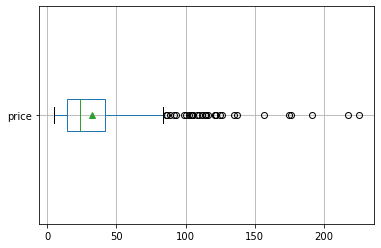

In [41]:
df2.boxplot('price', vert=False, showmeans=True)
plt.rcParams['figure.figsize'] = (7,8)
plt.show()

### Regardons à présent la liste de ces outliers

In [56]:
df_outlier = df2[df2['price'] >= 85]
df_outlier

,product_id,onsale_web,price,stock_quantity,stock_status,id_web,total_sales,post_author,post_date,CA / produit
63,4115,1,100.0,11,instock,15382,0,2,13/02/2018 11:08,0.0
65,4132,1,88.4,5,instock,11668,0,2,13/02/2018 11:43,0.0
199,4352,1,225.0,0,outofstock,15940,5,2,02/03/2018 10:30,1125.0
201,4355,1,126.5,2,instock,12589,11,2,02/03/2018 10:46,1391.5
205,4359,1,85.6,0,outofstock,13853,1,2,02/03/2018 11:11,85.6
218,4402,1,176.0,8,instock,3510,13,2,22/03/2018 11:21,2288.0
219,4404,1,108.5,2,instock,3507,2,2,22/03/2018 11:32,217.0
221,4406,1,157.0,3,instock,7819,0,2,22/03/2018 11:42,0.0
222,4407,1,104.0,6,instock,3509,1,2,22/03/2018 11:49,104.0
227,4582,1,109.6,7,instock,12857,0,2,12/04/2018 17:56,0.0


In [57]:
# Somme de la colonne CA/produit des outliers
ca_outlier = df_outlier['CA / produit'].sum()
ca_outlier

6970.0

### Que représente les ouliers dans notre CA total

In [58]:
pourcent_outlier = round(ca_outlier/CA*100,2)

In [59]:
pourcent_outlier

9.88

### Le chiffre d'afffaire total des produits dont le prix de vente est supérieur à 85 (outliers) est de 6970

### Le pourcentage du CA outliers sur le CA total est de 9,88%

### Nous sommes en présence de prix dont la valeurs sont atypiques et non aberrantes, rien d'anormal donc

In [60]:
df_normal = df2[df2['price'] < 85]

In [65]:
nb_vente_total = df_normal['total_sales'].sum()
nb_vente_outlier = df_outlier['total_sales'].sum()
print(nb_vente_total)
print(nb_vente_outlier)

2820
45


In [79]:
prtg_vente_outlier = round(nb_vente_outlier/nb_vente_total*100,2)
prtg_vente_outlier

1.6

## 9,88 % du chiffre d'affaires est réalisé par 1,6 % du nombres de ventes donc s'intéresser au prix de vente supérieur à 85 euros (outliers) pour augmenter le chiffres d'affaires n'est pas une mauvaise idée.

# FIN DE L'ANALYSE